<a href="https://colab.research.google.com/github/Zhalil24/BreastMRI-CNN-Classification/blob/main/EfficientNet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# 1. Cihaz Ayarı (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

!cp "/content/drive/MyDrive/data_set_zip/breast_mri_dataset.rar" /content/
!unrar x /content/breast_mri_dataset.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8061.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8253.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8422.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8489.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8575.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8605.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8659.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8680.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8693.jpg      78%  OK 
Extracti

In [4]:
# 2. Veri Hazırlığı ve Augmentation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [5]:
# Veri setlerini yükleme
data_dir = '/content/breast_mri_dataset'
train_dataset_full = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)

def create_model():
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    for i in range(3, len(model.features)):
        for param in model.features[i].parameters():
            param.requires_grad = True

    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)

    return model.to(device)

In [6]:
# 4. Diferansiyel Öğrenme Oranı Ayarı
def get_optimizer(model):
    params_groups = [
        {'params': model.features[3:4].parameters(), 'lr': 1e-5}, # layer 2
        {'params': model.features[4:6].parameters(), 'lr': 5e-5}, # layer 3
        {'params': model.features[6:].parameters(), 'lr': 1e-4},  # layer 4
        {'params': model.classifier.parameters(), 'lr': 1e-3}     # fc
    ]
    optimizer = optim.Adam(params_groups)
    return optimizer

In [7]:
# 5-Fold Stratified Cross-Validation Eğitimi
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
targets = train_dataset_full.targets
fold_results = []

print("--- 5-Fold Eğitim Başlıyor ---")
targets_np = np.array(targets)

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets_np)), targets_np)):
    print(f"\n{"="*20}")
    print(f"Fold {fold+1}/5")
    print(f"{"="*20}")

    train_sub = Subset(train_dataset_full, train_idx)
    val_sub = Subset(train_dataset_full, val_idx)

    train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=32, shuffle=False)

    model = create_model().to(device)
    optimizer = get_optimizer(model)
    criterion = nn.CrossEntropyLoss()

    epochs = 10
    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # --- EĞİTİM ADIMI ---
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        epoch_acc = correct.double() / len(train_sub)

        model.eval()
        v_correct = 0
        with torch.no_grad():
            for v_inputs, v_labels in val_loader:
                v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
                v_outputs = model(v_inputs)
                _, v_preds = torch.max(v_outputs, 1)
                v_correct += torch.sum(v_preds == v_labels.data)

        val_acc = v_correct.double() / len(val_sub)

        history['train_acc'].append(epoch_acc.item())
        history['val_acc'].append(val_acc.item())

        print(f"Epoch {epoch+1}/{epochs}: Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")

    fold_results.append(history)

print("\n--- Tüm Foldlar Başarıyla Tamamlandı ---")

--- 5-Fold Eğitim Başlıyor ---

Fold 1/5
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 201MB/s]


Epoch 1/10: Train Acc: 0.7500, Val Acc: 0.8654
Epoch 2/10: Train Acc: 0.8681, Val Acc: 0.9055
Epoch 3/10: Train Acc: 0.9048, Val Acc: 0.9385
Epoch 4/10: Train Acc: 0.9322, Val Acc: 0.9563
Epoch 5/10: Train Acc: 0.9438, Val Acc: 0.9581
Epoch 6/10: Train Acc: 0.9491, Val Acc: 0.9697
Epoch 7/10: Train Acc: 0.9568, Val Acc: 0.9762
Epoch 8/10: Train Acc: 0.9640, Val Acc: 0.9727
Epoch 9/10: Train Acc: 0.9704, Val Acc: 0.9753
Epoch 10/10: Train Acc: 0.9724, Val Acc: 0.9804

Fold 2/5
Epoch 1/10: Train Acc: 0.7445, Val Acc: 0.8591
Epoch 2/10: Train Acc: 0.8710, Val Acc: 0.9141
Epoch 3/10: Train Acc: 0.9056, Val Acc: 0.9290
Epoch 4/10: Train Acc: 0.9285, Val Acc: 0.9554
Epoch 5/10: Train Acc: 0.9400, Val Acc: 0.9560
Epoch 6/10: Train Acc: 0.9514, Val Acc: 0.9643
Epoch 7/10: Train Acc: 0.9571, Val Acc: 0.9700
Epoch 8/10: Train Acc: 0.9651, Val Acc: 0.9780
Epoch 9/10: Train Acc: 0.9678, Val Acc: 0.9762
Epoch 10/10: Train Acc: 0.9699, Val Acc: 0.9795

Fold 3/5
Epoch 1/10: Train Acc: 0.7499, Val Acc

In [8]:
# 6. Test Seti Değerlendirme
print("\n--- Test Seti Üzerinde Final Değerlendirme ---")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model.eval()

y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy())

# Metriklerin Hesaplanması
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_true, y_probs):.4f}")


--- Test Seti Üzerinde Final Değerlendirme ---
Accuracy:  0.9728
Precision: 0.9953
Recall:    0.9501
F1-Score:  0.9722
ROC-AUC:   0.9987


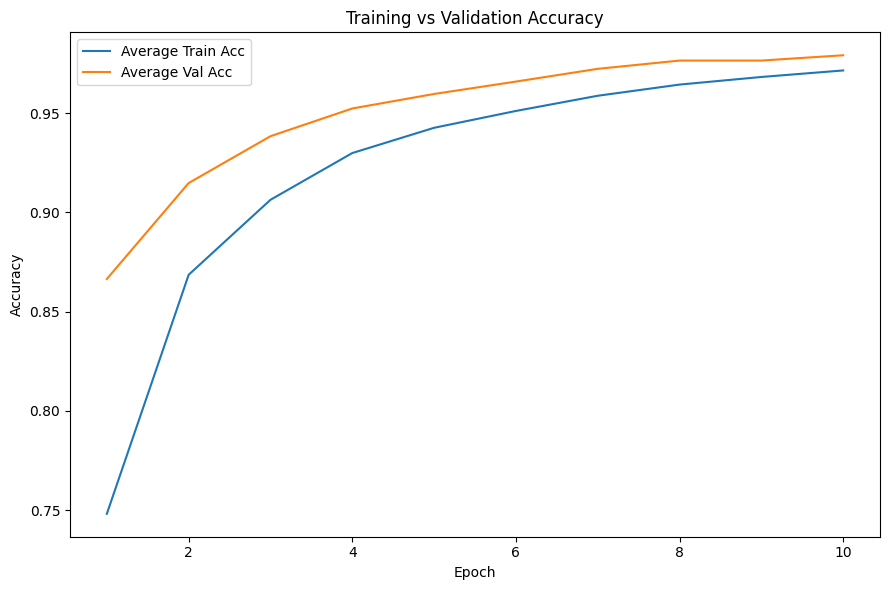

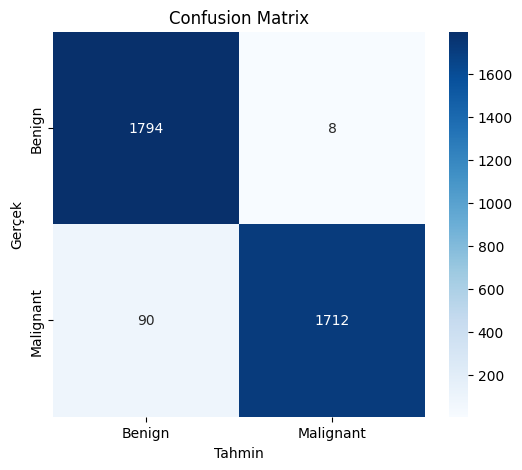

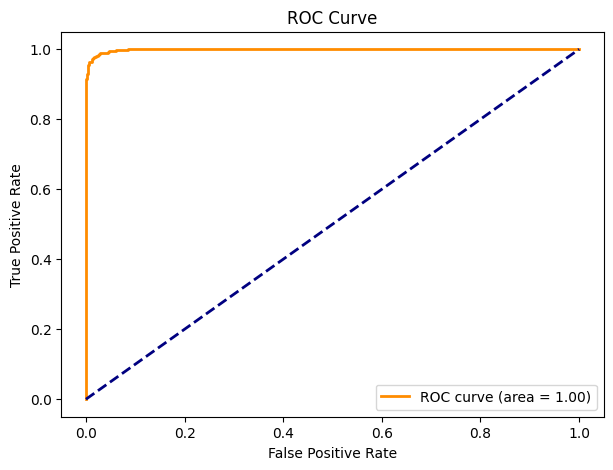

In [9]:

epochs_count = len(fold_results[0]['train_acc'])
sum_train_acc = np.zeros(epochs_count)
sum_val_acc = np.zeros(epochs_count)

for history_fold in fold_results:
    sum_train_acc += np.array(history_fold['train_acc'])
    sum_val_acc += np.array(history_fold['val_acc'])

avg_train_acc = sum_train_acc / len(fold_results)
avg_val_acc = sum_val_acc / len(fold_results)

# Plot 1: Accuracy Grafiği (Tüm foldların ortalaması)
plt.figure(figsize=(9, 6))
plt.plot(range(1, epochs_count + 1), avg_train_acc, label='Average Train Acc')
plt.plot(range(1, epochs_count + 1), avg_val_acc, label='Average Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# B. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

# C. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_true, y_probs):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()